0.021 안에서 고장을 Ball,InnerRace, OuterRace12, OuterRace3, OuterRace6 5가지 경우로 나누고 하나를 정상, 나머지를 고장으로 하여 실험

In [1]:
import cwru                      # Case Western Reserve University Bearing Data
import pandas as pd              # dataframe
import numpy as np               # array
from collections import Counter  # Class 갯수 세기
import matplotlib.pyplot as plt  # Visualization
%matplotlib inline
from scipy.fftpack import fft, ifft
from acoustics.cepstrum import complex_cepstrum, real_cepstrum
from sklearn.preprocessing import scale
from scipy.spatial import distance
from numpy.linalg import inv

In [450]:
cwru_data = cwru.CWRU("12DriveEndFault", "1750", 12000)

In [451]:
#cwru_data.labels

In [452]:
x_train = np.asarray(cwru_data.X_train)
x_test = np.asarray(cwru_data.X_test)

y_train = np.asarray(cwru_data.y_train)
y_test = np.asarray(cwru_data.y_test)

In [453]:
print(Counter(y_train)) # Train 데이터 클래스 분포
print(Counter(y_test))  # Test 데이터 클래스 분포

Counter({15: 30, 0: 7, 1: 7, 2: 7, 3: 7, 4: 7, 5: 7, 6: 7, 7: 7, 8: 7, 9: 7, 10: 7, 11: 7, 12: 7, 13: 7, 14: 7})
Counter({15: 10, 0: 3, 1: 3, 2: 3, 3: 3, 4: 3, 5: 3, 6: 3, 7: 3, 8: 3, 9: 3, 10: 3, 11: 3, 12: 3, 13: 3, 14: 3})


In [454]:
mils_21_train_idx, = np.where((y_train == 8) | (y_train == 9) | (y_train == 10) | (y_train == 11) | (y_train == 12))
mils_21_test_idx, = np.where((y_test == 8) | (y_test == 9) | (y_test == 10) | (y_test == 11) | (y_test == 12))

In [455]:
# remove class 15
x_train = x_train[mils_21_train_idx]
x_test = x_test[mils_21_test_idx]

y_train = y_train[mils_21_train_idx]
y_test = y_test[mils_21_test_idx]

In [456]:
# k class is abnormal
def make_dataset(AbnormalType):
    tp = AbnormalType
    
    if tp == 'Ball':
        normal_train_idx, = np.where((y_train != 8))
        normal_test_idx, = np.where((y_test != 8))

        abnormal_train_idx, = np.where((y_train == 8))
        abnormal_test_idx, = np.where((y_test == 8))
        
    elif tp == 'InnerRace':
        normal_train_idx, = np.where((y_train != 9))
        normal_test_idx, = np.where((y_test != 9))

        abnormal_train_idx, = np.where((y_train == 9))
        abnormal_test_idx, = np.where((y_test == 9))
        
    elif tp == 'OuterRace12':
        normal_train_idx, = np.where((y_train != 10))
        normal_test_idx, = np.where((y_test != 10))

        abnormal_train_idx, = np.where((y_train == 10))
        abnormal_test_idx, = np.where((y_test == 10))
        
    elif tp == 'OuterRace3':
        normal_train_idx, = np.where((y_train != 11))
        normal_test_idx, = np.where((y_test != 11))

        abnormal_train_idx, = np.where((y_train == 11))
        abnormal_test_idx, = np.where((y_test == 11))
        
    elif tp == 'OuterRace6':
        normal_train_idx, = np.where((y_train != 12))
        normal_test_idx, = np.where((y_test != 12))

        abnormal_train_idx, = np.where((y_train == 12))
        abnormal_test_idx, = np.where((y_test == 12))
        
    else:
        print('Typing Error')
    
    return normal_train_idx, normal_test_idx, abnormal_train_idx, abnormal_test_idx
    

In [457]:
normal_train_idx, normal_test_idx, abnormal_train_idx, abnormal_test_idx = make_dataset('Ball')

for i in range(len(y_train)):
    if i in normal_train_idx:
        y_train[i] = 0 # Normal
    else:
        y_train[i] = 1 # Abnormal 

# Test 데이터 클래스 수정
for i in range(len(y_test)):
    if i in normal_test_idx:
        y_test[i] = 0
    else:
        y_test[i] = 1 
            

In [458]:
def do_FFT(signal_set):
    window = np.hamming(12000)
    fft_rlt = np.fft.fft(window * signal_set)
    return(fft_rlt)

def do_Cepstrum(spectrum):
    cep_result = (ifft(np.log(spectrum**2))**2).real
    return(cep_result)

    #ifft(np.log(np.abs(spectrum)))

In [459]:
#Data split
normal_x_train = pd.DataFrame(x_train[normal_train_idx])
normal_x_test = pd.DataFrame(x_test[normal_test_idx])

abnormal_x_train = pd.DataFrame(x_train[abnormal_train_idx])
abnormal_x_test = pd.DataFrame(x_test[abnormal_test_idx])

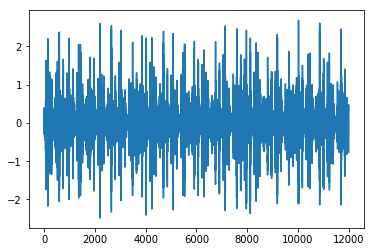

In [460]:
plt.plot(normal_x_train.iloc[0,:])

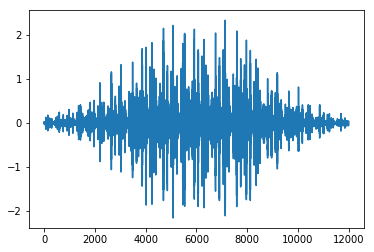

In [461]:
plt.plot(normal_x_train.iloc[0,:]*np.hamming(12000))

In [462]:
#Standardization
normal_x_train_scaled = pd.DataFrame(scale(normal_x_train, axis = 1))
normal_x_test_scaled = pd.DataFrame(scale(normal_x_test, axis = 1))

abnormal_x_train_scaled = pd.DataFrame(scale(abnormal_x_train, axis = 1))
abnormal_x_test_scaled = pd.DataFrame(scale(abnormal_x_test, axis = 1))

'''
#No-Standardization
normal_x_train_scaled = normal_x_train
normal_x_test_scaled = normal_x_test

abnormal_x_train_scaled = abnormal_x_train
abnormal_x_test_scaled = abnormal_x_test
'''

'\n#No-Standardization\nnormal_x_train_scaled = normal_x_train\nnormal_x_test_scaled = normal_x_test\n\nabnormal_x_train_scaled = abnormal_x_train\nabnormal_x_test_scaled = abnormal_x_test\n'

In [463]:
#Hamming and FFT
normal_x_train_fft = np.apply_along_axis(do_FFT, 1, normal_x_train_scaled)
normal_x_test_fft = np.apply_along_axis(do_FFT, 1, normal_x_test_scaled)

abnormal_x_train_fft = np.apply_along_axis(do_FFT, 1, abnormal_x_train_scaled)
abnormal_x_test_fft = np.apply_along_axis(do_FFT, 1, abnormal_x_test_scaled)

Text(0,0.5,'|Y(freq)|')

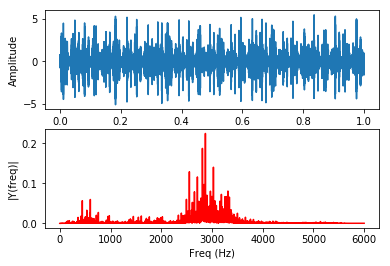

In [464]:
Fs = 12000.0;  # sampling rate
Ts = 1.0/Fs; # sampling interval
t = np.arange(0,1,Ts) # time vector

y = normal_x_train_scaled.iloc[0,:]

n = len(y) # length of the signal
k = np.arange(n)
T = n/Fs
frq = k/T # two sides frequency range
frq = frq[range(n/2)] # one side frequency range

Y = np.fft.fft(y)/n # fft computing and normalization
Y = Y[range(n/2)]

fig, ax = plt.subplots(2, 1)
ax[0].plot(t,y)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')
ax[1].plot(frq,abs(Y),'r') # plotting the spectrum
ax[1].set_xlabel('Freq (Hz)')
ax[1].set_ylabel('|Y(freq)|')


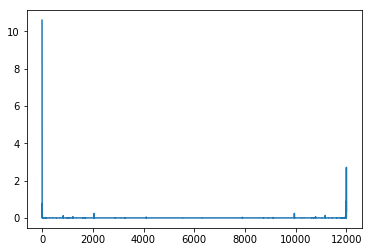

In [465]:
#Cepstrum
normal_x_train_cep = np.apply_along_axis(do_Cepstrum, 1, normal_x_train_fft)
normal_x_test_cep = np.apply_along_axis(do_Cepstrum, 1, normal_x_test_fft)

abnormal_x_train_cep = np.apply_along_axis(do_Cepstrum, 1, abnormal_x_train_fft)
abnormal_x_test_cep = np.apply_along_axis(do_Cepstrum, 1, abnormal_x_test_fft)

plt.plot(normal_x_train_cep[0])

In [466]:
#SI Functions
def get_mean(x):
    avg = np.mean(x)
    return(avg)

def get_std(x):
    std = np.std(x)
    return(std)

def get_skewness(x):
    skewness = sum((x - np.mean(x))**3) / ((len(x)-1)*(np.std(x)**3))
    return(skewness)

def get_kurtosis(x):
    kurtosis = sum((x - np.mean(x))**4) / ((len(x)-1)*(np.std(x)**4))
    return (kurtosis)

def get_p2p(x):
    p2p = (np.max(x) - np.min(x))
    return(p2p)

def get_rms(x):
    rms = np.sqrt(sum(x**2) / len(x))
    return(rms)

def get_crestFactor(x):
    crestFactor = get_p2p(x) / get_rms(x)
    return(crestFactor)

def get_shapeFactor(x):
    shapeFactor = get_rms(x) / get_mean(x)
    return(shapeFactor)
    
def get_marginFactor(x):
    marginFactor = np.max(x) / (np.mean((np.sqrt(abs(x))))**2)
    return(marginFactor)

def get_impulseFactor(x):
    impulseFactor = np.max(x) / np.mean(abs(x))
    return(impulseFactor)


In [467]:
def make_df(x):
    mean_value = np.apply_along_axis(get_mean, 1, x)
    std_value = np.apply_along_axis(get_std, 1, x)
    skewness_value = np.apply_along_axis(get_skewness, 1, x)
    kurtosis_value = np.apply_along_axis(get_kurtosis, 1, x)
    p2p_value = np.apply_along_axis(get_p2p, 1, x)
    rms_value = np.apply_along_axis(get_rms, 1, x)
    crestFactor_value = np.apply_along_axis(get_crestFactor, 1, x)
    shapeFactor_value = np.apply_along_axis(get_shapeFactor, 1, x)
    marginFactor_value = np.apply_along_axis(get_marginFactor, 1, x)
    impulseFactor_value = np.apply_along_axis(get_impulseFactor, 1, x)
    
    df = pd.DataFrame({'mean':mean_value, 'std':std_value, 'skewness':skewness_value, 'kurtosis':kurtosis_value, 'p2p':p2p_value, 'rms':rms_value,
                       'crest':crestFactor_value, 'shape':shapeFactor_value, 'margin':marginFactor_value, 'impulse':impulseFactor_value})
    
    return(df)

In [468]:
#make dataframe
normal_x_train_SI = make_df(normal_x_train_cep)
normal_x_test_SI = make_df(normal_x_test_cep)

abnormal_x_train_SI = make_df(abnormal_x_train_cep)
abnormal_x_test_SI = make_df(abnormal_x_test_cep)

In [469]:
#Standardization in MTS
def standardize(x,y):
    mean_mean = get_mean(x['mean'])
    std_mean = get_mean(x['std'])
    skewness_mean = get_mean(x['skewness'])
    kurtosis_mean = get_mean(x['kurtosis'])
    p2p_mean = get_mean(x['p2p'])
    rms_mean = get_mean(x['rms'])
    crest_mean = get_mean(x['crest'])
    shape_mean = get_mean(x['shape'])
    margin_mean = get_mean(x['margin'])
    impulse_mean = get_mean(x['impulse'])
    
    mean_std = get_std(x['mean'])
    std_std = get_std(x['std'])
    skewness_std = get_std(x['skewness'])
    kurtosis_std = get_std(x['kurtosis'])
    p2p_std = get_std(x['p2p'])
    rms_std = get_std(x['rms'])
    crest_std = get_std(x['crest'])
    shape_std = get_std(x['shape'])
    margin_std = get_std(x['margin'])
    impulse_std = get_std(x['impulse'])
    
    mean_value = (y['mean'] - mean_mean) / mean_std
    std_value = (y['std'] - std_mean) / std_std
    skewness_value = (y['skewness'] - skewness_mean) / skewness_std
    kurtosis_value = (y['kurtosis'] - kurtosis_mean) / kurtosis_std
    p2p_value = (y['p2p'] - p2p_mean) / p2p_std
    rms_value = (y['rms'] - rms_mean) / rms_std
    crest_value = (y['crest'] - crest_mean) / crest_std
    shape_value = (y['shape'] - shape_mean) / shape_std
    margin_value = (y['margin'] - margin_mean) / margin_std
    impulse_value = (y['impulse'] - impulse_mean) / impulse_std
    
    df = pd.DataFrame({'mean':mean_value, 'std':std_value, 'skewness':skewness_value, 'kurtosis':kurtosis_value, 'p2p':p2p_value, 'rms':rms_value,
                       'crest':crest_value, 'shape':shape_value, 'margin':margin_value, 'impulse':impulse_value})
    
    return(df)

In [470]:
normal_x_train_SI_scaled = standardize(normal_x_train_SI, normal_x_train_SI)
normal_x_test_SI_scaled = standardize(normal_x_train_SI, normal_x_test_SI)

abnormal_x_train_SI_scaled = standardize(normal_x_train_SI, abnormal_x_train_SI)
abnormal_x_test_SI_scaled = standardize(normal_x_train_SI, abnormal_x_test_SI)

In [471]:
def get_MD_distance(x):
    normal_cov_mat = pd.DataFrame(normal_x_train_SI_scaled).corr()
    dist = np.matmul(np.matmul(x, inv(normal_cov_mat)), np.transpose(x)) / len(x)
    return(dist)

In [472]:
normal_train_dist = np.apply_along_axis(get_MD_distance, 1, normal_x_train_SI_scaled)
normal_train_dist.sort()
normal_test_dist = np.apply_along_axis(get_MD_distance, 1, normal_x_test_SI_scaled)
normal_test_dist.sort()

abnormal_train_dist = np.apply_along_axis(get_MD_distance, 1, abnormal_x_train_SI_scaled)
abnormal_train_dist.sort()
abnormal_test_dist = np.apply_along_axis(get_MD_distance, 1, abnormal_x_test_SI_scaled)
abnormal_test_dist.sort()


In [473]:
print(normal_train_dist)
print('\n')
print(normal_test_dist)
print('\n')
print(abnormal_train_dist)
print('\n')
print(abnormal_test_dist)


[0.34985764 0.41142422 0.41308614 0.50553867 0.52614473 0.58921663
 0.59422189 0.63056945 0.65168277 0.65779813 0.66303691 0.69514418
 0.70612995 0.72890632 0.72941761 0.74948428 0.93510448 0.93659565
 0.96153174 1.02005849 1.05582308 1.17317272 1.19611021 1.9014812
 2.12796618 2.28629807 2.28777368 2.51390952]


[0.38000824 0.45006229 0.7231624  0.7337525  0.95649267 1.28550447
 1.39746822 1.72695002 1.74893213 1.86123241 2.01301528 3.9917622 ]


[12.0710722  16.13114157 16.20274259 19.36037502 20.58021966 21.3511216
 23.91859463]


[16.21714866 18.63069394 30.30222142]


In [474]:
#L_12(2^11) orthogonal array
ortho_array = np.matrix([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2],
                       [1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2],
                       [1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2],
                       [1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1],
                       [1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1],
                       [2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1],
                       [2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2],
                       [2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1],
                       [2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2],
                       [2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2],
                       [2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1]])

In [475]:
otho_df = pd.DataFrame(ortho_array, columns=['mean', 'std', 'skewness', 'kurtosis', 'p2p', 'rms', 'crest', 'shape', 'margin', 'impulse','DUMMY'])

In [476]:
def get_exp_col(n):
    condition = otho_df.iloc[n,:]==1
    col = list(otho_df.loc[n,condition].index)
    if('DUMMY' in col):
        col.pop()
    return(col)

In [477]:
def get_MD_distance_exp(x,n):
    col = get_exp_col(n)
    normal_cov_mat = pd.DataFrame(normal_x_train_SI_scaled[col]).corr()
    dist = np.matmul(np.matmul(x, inv(normal_cov_mat)), np.transpose(x)) / len(x)
    return(dist)

In [478]:
def get_MD_exp(n,df):
    col = get_exp_col(n)
    target_df = df[col]
    dist = np.apply_along_axis(get_MD_distance_exp, 1, target_df, n)
    return(dist)

In [479]:
def get_MD_matrix(df):
    arr = np.empty([12, df.shape[0]])
    for i in range(0,12):
        arr[i,:] = get_MD_exp(i,df)
        
    return(arr)

In [480]:
normal_x_test_MD_matrix = get_MD_matrix(normal_x_test_SI_scaled)

abnormal_x_train_MD_matrix = get_MD_matrix(abnormal_x_train_SI_scaled)
abnormal_x_test_MD_matrix = get_MD_matrix(abnormal_x_test_SI_scaled)


In [481]:
def cal_larger_better_SNRatio(mat):
    SNRatio = []
    for i in range(0,mat.shape[0]):
        dist = mat[i]
        SN = -10 * np.log10(np.mean(1/(dist)))
        SNRatio.append(SN)
        
    return(SNRatio)

In [482]:
def cal_smaller_better_SNRatio(mat):
    SNRatio = []
    for i in range(0,mat.shape[0]):
        dist = mat[i]
        SN = -10 * np.log10(np.mean(dist))
        SNRatio.append(SN)
        
    return(SNRatio)

In [483]:
SNRatio_normal_test = cal_smaller_better_SNRatio(normal_x_test_MD_matrix)

SNRatio_abnormal_train = cal_larger_better_SNRatio(abnormal_x_train_MD_matrix)
SNRatio_abnormal_test = cal_larger_better_SNRatio(abnormal_x_test_MD_matrix)

In [484]:
def cal_smaller_better_gain(mat,col_name):
    idx_1 = list(otho_df.loc[otho_df[col_name] == 1].index)
    idx_2 = list(otho_df.loc[otho_df[col_name] == 2].index)
    
    SN = np.array(cal_smaller_better_SNRatio(mat))
    values_1 = np.mean(SN[idx_1])
    values_2 = np.mean(SN[idx_2])
    
    gain = values_1 - values_2
    
    return(gain)

In [485]:
def cal_larger_better_gain(mat,col_name):
    idx_1 = list(otho_df.loc[otho_df[col_name] == 1].index)
    idx_2 = list(otho_df.loc[otho_df[col_name] == 2].index)
    
    SN = np.array(cal_larger_better_SNRatio(mat))
    values_1 = np.mean(SN[idx_1])
    values_2 = np.mean(SN[idx_2])
    
    gain = values_1 - values_2
    
    return(gain)

In [486]:
#get gain
column_names=['mean', 'std', 'skewness', 'kurtosis', 'p2p', 'rms', 'crest', 'shape', 'margin', 'impulse']

def get_normal_test_gain(col):
    columns = col
    gain_values = []
    for i in range(0,len(columns)):
        gain_values.append(cal_smaller_better_gain(normal_x_test_MD_matrix, columns[i]))
        
    return(gain_values)
 
def get_abnormal_train_gain(col):
    columns = col
    gain_values = []
    for i in range(0,len(columns)):
        gain_values.append(cal_larger_better_gain(abnormal_x_train_MD_matrix, columns[i]))
        
    return(gain_values)

def get_abnormal_test_gain(col):
    columns = col
    gain_values = []
    for i in range(0,len(columns)):
        gain_values.append(cal_larger_better_gain(abnormal_x_test_MD_matrix, columns[i]))
        
    return(gain_values)

In [487]:
normal_test_gain = get_normal_test_gain(column_names)

abnormal_train_gain = get_abnormal_train_gain(column_names)
abnormal_test_gain = get_abnormal_test_gain(column_names)

In [488]:
print('normal_test_gain')
print(pd.DataFrame(normal_test_gain, index=column_names))
print('\n')

print('abnormal_train_gain')
print(pd.DataFrame(abnormal_train_gain, index=column_names))
print('\n')

print('abnormal_test_gain')
print(pd.DataFrame(abnormal_test_gain, index=column_names))

normal_test_gain
                 0
mean      0.022060
std       0.371384
skewness -0.390627
kurtosis -0.201628
p2p      -0.290152
rms      -0.065283
crest    -0.397694
shape     0.070817
margin   -0.252237
impulse  -0.390656


abnormal_train_gain
                 0
mean     -1.964425
std       1.244793
skewness  2.411567
kurtosis -2.310084
p2p       1.806259
rms       1.894354
crest    -0.887728
shape     2.067514
margin    9.594781
impulse   1.705355


abnormal_test_gain
                 0
mean     -2.133828
std       1.655447
skewness  2.437137
kurtosis -2.496522
p2p       2.380708
rms       2.206080
crest    -0.940672
shape     2.428471
margin    7.776287
impulse   1.801388


In [493]:
# Select variables that show positive SN ratio in Normal test

variables = ['margin','skewness']

normal_train_taguchi = normal_x_train_SI_scaled[variables]
normal_test_taguchi = normal_x_test_SI_scaled[variables]

abnormal_train_taguchi = abnormal_x_train_SI_scaled[variables]
abnormal_test_taguchi = abnormal_x_test_SI_scaled[variables]

def get_MD_distance_taguchi(x):
    normal_cov_mat = pd.DataFrame(normal_train_taguchi).corr()
    dist = np.matmul(np.matmul(x, inv(normal_cov_mat)), np.transpose(x)) / len(x)
    return(dist)

normal_train_dist_taguchi = np.apply_along_axis(get_MD_distance_taguchi, 1, normal_train_taguchi)
normal_train_dist_taguchi.sort()
normal_test_dist_taguchi = np.apply_along_axis(get_MD_distance_taguchi, 1, normal_test_taguchi)
normal_test_dist_taguchi.sort()

abnormal_train_dist_taguchi = np.apply_along_axis(get_MD_distance_taguchi, 1, abnormal_train_taguchi)
abnormal_train_dist_taguchi.sort()
abnormal_test_dist_taguchi = np.apply_along_axis(get_MD_distance_taguchi, 1, abnormal_test_taguchi)
abnormal_test_dist_taguchi.sort()

# Results of Feature selection
print('Normal Train (Mahalanobis Space)')
print(normal_train_dist_taguchi)
print('\n')

print('Normal Test')
print(normal_test_dist_taguchi)
print('\n')

print('Abnormal Train')
print(abnormal_train_dist_taguchi)
print('\n')

print('Abnormal Test')
print(abnormal_test_dist_taguchi)

Normal Train (Mahalanobis Space)
[0.07186352 0.13659476 0.21998432 0.25412388 0.3309795  0.34173513
 0.53066444 0.56552384 0.60031775 0.60986519 0.61235437 0.63930884
 0.69405524 0.79075337 0.87011845 0.94073208 1.03238176 1.08019687
 1.25309977 1.2581131  1.374244   1.38333726 1.50982646 1.72840063
 1.79712405 1.83880848 2.0888239  3.44666901]


Normal Test
[0.15316761 0.572778   0.78818135 0.82133428 0.95722124 0.98287272
 1.04837272 1.11919944 1.53280792 1.64106161 2.17922068 2.48231698]


Abnormal Train
[1.11133205 1.38349805 2.06694399 2.07703884 2.37960367 2.62134739
 3.68895409]


Abnormal Test
[1.06753036 1.31828801 2.37933981]
